<a href="https://colab.research.google.com/github/covid-vdas/mafia-ai/blob/main/YOLOv5_Training_(Minimized).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Set up environment

<font size="5">&ndash;&nbsp;&nbsp;Mount Google Drive & Set up</font>

In [ ]:
# Drive Mount workaround
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-ge\t update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

# Imports & YOLOv5 setup

import os

yolov5_dir = '/content/yolov5'
%cd /content

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd $yolov5_dir
%pip install -qr requirements.txt        # install dependencies
%pip install wandb                       # install wandb (Weights & Biases - wandb.ai)

import torch
import glob
from IPython.display import Image, clear_output   # to display images

from yolov5 import utils
display = utils.notebook_init()          # setup checks

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# Get the latest subdir of a specified directory (sorted by last modified criterion)

def find_latest_modified_subdir(parent_directory):
    return max([os.path.join(parent_directory, dir) for dir in os.listdir(parent_directory)], key=os.path.getmtime)

YOLOv5 🚀 v6.0-255-gca0a007 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 42.3/166.8 GB disk)
Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

# Imports

import os

# YOLOv5 setup

yolov5_dir = '/content/yolov5'

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd $yolov5_dir
%pip install -qr requirements.txt        # install dependencies
%pip install wandb                       # install wandb (Weights & Biases - wandb.ai)

import torch
import glob
from IPython.display import Image, clear_output   # to display images

from yolov5 import utils
display = utils.notebook_init()          # setup checks

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# Get the latest subdir of a specified directory (sorted by last modified criterion)
def find_latest_modified_subdir(parent_directory):
    return max([os.path.join(parent_directory, dir) for dir in os.listdir(parent_directory)], key=os.path.getmtime)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<font size="5">&ndash;&nbsp;&nbsp;Import the datasets </font>

In [ ]:
# Local & Drive directories

image_dir_local  = '/content/images'          # change according to yaml
label_dir_local  = '/content/labels'          # change according to yaml
yaml_dir_local   = '/content/'                # don't alter (unless necessary)
pretrained_local = '/content/'                 # don't alter (unless necessary)

yaml_name               = 'vdas-person.yaml'    # CHANGE THIS EVERY RUN
pretrained_weights_name = 'best-0214.pt'            # CHANGE THIS EVERY RUN

image_dir_drive  = '/content/drive/MyDrive/yolo/4-datasets/coco-person-5-parts/train2017-part-2.zip'      # CHANGE THIS EVERY RUN
label_dir_drive  = '/content/drive/MyDrive/yolo/4-datasets/coco-person-5-parts/labels2017-part-2.zip'      # CHANGE THIS EVERY RUN
yaml_dir_drive   = os.path.join('/content/drive/MyDrive/yolo/', yaml_name)
pretrained_drive = os.path.join('/content/drive/MyDrive/yolo/1-weights/', pretrained_weights_name)

# Create local directories

os.makedirs(image_dir_local,  exist_ok=True)
os.makedirs(label_dir_local,  exist_ok=True)
os.makedirs(yaml_dir_local,   exist_ok=True)
os.makedirs(pretrained_local, exist_ok=True)

# Unzip images & labels from Drive to local directories

!unzip $image_dir_drive -d $image_dir_local
!unzip $label_dir_drive -d $label_dir_local

# Copy custom yaml & pretrained weights file

!cp $yaml_dir_drive $yaml_dir_local
!cp $pretrained_drive $pretrained_local

Streaming output truncated to the last 5000 lines.
 extracting: /content/labels/train/000000382640.txt  
 extracting: /content/labels/train/000000132913.txt  
 extracting: /content/labels/train/000000129914.txt  
 extracting: /content/labels/train/000000157586.txt  
 extracting: /content/labels/train/000000454436.txt  
 extracting: /content/labels/train/000000091310.txt  
 extracting: /content/labels/train/000000192944.txt  
 extracting: /content/labels/train/000000172673.txt  
 extracting: /content/labels/train/000000346140.txt  
 extracting: /content/labels/train/000000514515.txt  
 extracting: /content/labels/train/000000396972.txt  
 extracting: /content/labels/train/000000147226.txt  
 extracting: /content/labels/train/000000422367.txt  
 extracting: /content/labels/train/000000344146.txt  
 extracting: /content/labels/train/000000432138.txt  
 extracting: /content/labels/train/000000449889.txt  
 extracting: /content/labels/train/000000379837.txt  
 extracting: /content/labels/tr

# Step 2: Training

In [ ]:
!cp /content/drive/MyDrive/yolo/1-weights/best-0214.pt $pretrained_local

In [ ]:
# Data locations (Training)

yaml_dir               = os.path.join(yaml_dir_local,   yaml_name)
pretrained_weights_dir = os.path.join(pretrained_local, pretrained_weights_name)

# Arguments (Training)

image_size = 640
batch_size = 64
epochs     = 80
patience   = 35

# Kick off training 

!python train.py --img $image_size --batch $batch_size --epochs $epochs --data $yaml_dir --weights $pretrained_weights_dir --cache --patience $patience

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=/content/best-0214.pt, cfg=, data=/content/vdas-person.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=80, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=35, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=

In [ ]:
latest_train_dir = find_latest_modified_subdir('/content/yolov5/runs/train')
latest_weights   = os.path.join(latest_train_dir, 'weights', 'best.pt')

if not (os.path.isdir(latest_train_dir) and os.path.isfile(latest_weights)):
    %%script stop_code_here

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


# Step 3: Inference

In [ ]:
# Data locations (Inference)

test_data_local = '/content/traffic_data'   # source files for detection
test_data_drive = '/content/drive/MyDrive/yolov5/traffic_data.zip'

!unzip $test_data_drive -d $test_data_local

In [ ]:
# Arguments (Inference)

conf = 0.4    # confidence threshold

# Inference

!cd $yolov5_dir && python detect.py --weights $latest_weights --img $image_size --conf $conf --source /content/traffic_data/traffic_data

detect: weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], source=/content/traffic_data/traffic_data, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-152-g26f0415 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Traceback (most recent call last):
  File "detect.py", line 243, in <module>
    main(opt)
  File "detect.py", line 238, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 79, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
  File "/content/yolov5/models/common.py", line 309, in 

In [ ]:
latest_detect_dir = find_latest_modified_subdir('/content/yolov5/runs/detect')

if not os.path.isdir(latest_detect_dir):
    %%script stop_code_here

#&nbsp;[Optional]&emsp13;Display all inference images

In [ ]:
import glob

In [ ]:
# Arguments (Inference Results)

all = '*'     # default
png = '*.png' # change this based on image type

# Display inference on ALL test images

for imageName in glob.glob(os.path.join(latest_detect_dir, all)):
    display(Image(filename=imageName))
    print('\n')

TypeError: ignored

# Step 4: Validation (on 'test' set)

In [ ]:
# Arguments (Validation)

# task = 'test'
conf = 0.5      # confidence threshold

# Validation

!cd $yolov5_dir && python /content/yolov5/val.py --task test --weights /content/best-0214.pt --img 640 --conf 0.5 --data /content/vdas-person.yaml

val: data=/content/vdas-person.yaml, weights=['/content/best-0214.pt'], batch_size=64, imgsz=640, conf_thres=0.5, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
test: Scanning '/content/labels/test.cache' images and labels... 1283 found, 0 missing, 0 empty, 0 corrupt: 100% 1283/1283 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 21/21 [00:15<00:00,  1.33it/s]
                 all       1283       5182      0.861      0.658      0.782      0.589
Speed: 0.3ms pre-process, 3.7ms inference, 2.5ms NMS per image at shape (64, 3, 640, 640)
Results saved to runs/val/exp2


In [ ]:
# Arguments (Validation)

task = 'test'
conf = 0.5      # confidence threshold

# Validation

!cd $yolov5_dir && python /content/yolov5/val.py --task test --weights $latest_weights --img $image_size --conf $conf --data $yaml_dir

usage: val.py [-h] [--data DATA] [--weights WEIGHTS [WEIGHTS ...]]
              [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
              [--conf-thres CONF_THRES] [--iou-thres IOU_THRES] [--task TASK]
              [--device DEVICE] [--workers WORKERS] [--single-cls] [--augment]
              [--verbose] [--save-txt] [--save-hybrid] [--save-conf]
              [--save-json] [--project PROJECT] [--name NAME] [--exist-ok]
              [--half] [--dnn]
val.py: error: argument --weights: expected at least one argument


# Step 5: Save Output Data

<font size="5">&ndash;&nbsp;&nbsp;Get the latest directories </font>

In [ ]:
latest_train_dir  = find_latest_modified_subdir('/content/yolov5/runs/train')
# latest_detect_dir = find_latest_modified_subdir('/content/yolov5/runs/detect')
latest_val_dir    = find_latest_modified_subdir('/content/yolov5/runs/val')

FileNotFoundError: ignored

<font size="5">&ndash;&nbsp;&nbsp;Save Training Data </font>

In [ ]:
print(os.path.join(target_weights_dir, weights_name))

/content/drive/MyDrive/yolov5/weights/best-1220.pt


In [ ]:
# Naming & Directories

root_dir         = '/content/'
wandb_dir        = os.path.join(yolov5_dir, 'wandb/latest-run')
weights_zip_name = 'weights-0214.zip'                                       # CHANGE THIS EVERY RUN
wandb_name       = 'wandb-0214.zip'                                         # CHANGE THIS EVERY RUN
weights_name     = 'best-0214.pt'                                           # CHANGE THIS EVERY RUN

weights_zip      = os.path.join(root_dir, weights_zip_name)
wandb_zip        = os.path.join(root_dir, wandb_name)
weights_file     = os.path.join(latest_train_dir, 'weights', 'best.pt')     # assume best.pt (by default)
      
target_weights_zip_dir = '/content/drive/MyDrive/yolo/1-weights/zips'
target_wandb_dir       = '/content/drive/MyDrive/yolo/wandb'
target_weights_dir     = '/content/drive/MyDrive/yolo/1-weights'
target_weights_file    = os.path.join(target_weights_dir, weights_name)

if not (os.path.isfile(weights_file)):
    %%script stop_code_here

# Zip latest weights and wandb folders; then Save to Google Drive

!cd $latest_train_dir && zip -r -0 $weights_zip . && cp $weights_zip $target_weights_zip_dir
!cd $wandb_dir && zip -r -0 $wandb_zip . && cp $wandb_zip $target_wandb_dir

# Rename and move latest weights file to Google Drive
!mv $weights_file $target_weights_file

  adding: val_batch0_pred.jpg (stored 0%)
  adding: val_batch0_labels.jpg (stored 0%)
  adding: events.out.tfevents.1644816015.85410083e7ab.18575.0 (stored 0%)
  adding: labels.jpg (stored 0%)
  adding: opt.yaml (stored 0%)
  adding: val_batch2_pred.jpg (stored 0%)
  adding: hyp.yaml (stored 0%)
  adding: F1_curve.png (stored 0%)
  adding: results.csv (stored 0%)
  adding: train_batch0.jpg (stored 0%)
  adding: train_batch2.jpg (stored 0%)
  adding: weights/ (stored 0%)
  adding: weights/best.pt (stored 0%)
  adding: weights/last.pt (stored 0%)
  adding: val_batch1_pred.jpg (stored 0%)
  adding: PR_curve.png (stored 0%)
  adding: val_batch2_labels.jpg (stored 0%)
  adding: results.png (stored 0%)
  adding: labels_correlogram.jpg (stored 0%)
  adding: confusion_matrix.png (stored 0%)
  adding: P_curve.png (stored 0%)
  adding: val_batch1_labels.jpg (stored 0%)
  adding: train_batch1.jpg (stored 0%)
  adding: R_curve.png (stored 0%)
  adding: tmp/ (stored 0%)
  adding: tmp/code/ (stored 

<font size="5">&ndash;&nbsp;&nbsp;Save Inference Data </font>

In [ ]:
# Naming & Directories

detect_zip_name   = 'detect-1220.zip'                  # CHANGE THIS EVERY RUN         
detect_zip        = os.path.join(root_dir, detect_zip_name)
target_detect_dir = '/content/drive/MyDrive/yolov5/detect'

# Zip latest detect folder; then Save to Google Drive
!cd $latest_detect_dir && zip -r -0 $detect_zip . && cp $detect_zip $target_detect_dir

<font size="5">&ndash;&nbsp;&nbsp;Save Validation Data </font>

In [ ]:
# Naming & Directories

val_zip_name   = 'val-0214-2.zip'                  # CHANGE THIS EVERY RUN         
val_zip        = os.path.join(root_dir, val_zip_name)
target_val_dir = '/content/drive/MyDrive/yolo/3-vals'

# Zip latest val folder; then Save to Google Drive
# !cd $latest_val_dir && zip -r -0 $val_zip . && cp $val_zip $target_val_dir
!cd /content/yolov5/runs/val/exp2 && zip -r -0 $val_zip . && cp $val_zip $target_val_dir

  adding: val_batch0_pred.jpg (stored 0%)
  adding: val_batch0_labels.jpg (stored 0%)
  adding: val_batch2_pred.jpg (stored 0%)
  adding: F1_curve.png (stored 0%)
  adding: val_batch1_pred.jpg (stored 0%)
  adding: PR_curve.png (stored 0%)
  adding: val_batch2_labels.jpg (stored 0%)
  adding: confusion_matrix.png (stored 0%)
  adding: P_curve.png (stored 0%)
  adding: val_batch1_labels.jpg (stored 0%)
  adding: R_curve.png (stored 0%)


<font size="5">&ndash;&nbsp;&nbsp;Force sync to ensure data is saved </font>

In [ ]:
# Force sync only

drive.flush_and_unmount()

In [ ]:
# Force sync; then mount again

drive.flush_and_unmount()
drive._mount('/content/drive')

Mounted at /content/drive


# Legacy

In [ ]:
%cd /content/yolov5/runs/train/exp6
!zip -r -0 /content/weights-1218.zip .
!cp -r /content/weights-1218.zip /content/drive/MyDrive/yolov5/weights/zips

%cd /content/yolov5/wandb/latest-run
!zip -r -0 /content/wandb-1218.zip .
!cp -r /content/wandb-1218.zip /content/drive/MyDrive/yolov5/wandb

%cd /content/yolov5/runs/train/exp6/weights/best.pt
!mv /content/yolov5/runs/train/exp6/weights/best.pt /content/yolov5/runs/train/exp6/weights/best-1218.pt
!cp -r /content/yolov5/runs/train/exp6/weights/best-1218.pt /content/drive/MyDrive/yolov5/weights/zips

In [ ]:
%cd /content/yolov5/runs/detect/exp2
!zip -r -0 /content/detect-1218.zip .
!cp -r /content/detect-1218.zip /content/drive/MyDrive/yolov5/detect

%cd /content/yolov5/runs/val/exp
!zip -r -0 /content/val-1218.zip .
!cp -r /content/val-1218.zip /content/drive/MyDrive/yolov5/val

In [ ]:
%cd /content/yolov5
!python detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --img 640 --conf 0.4 --source /content/test

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/test, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-148-gc1249a4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 378 layers, 35295096 parameters, 0 gradients, 49.1 GFLOPs
image 1/10 /content/test/img_1.png: 320x640 5 vehicles, Done. (0.018s)
image 2/10 /content/test/img_10.png: 320x640 2 persons, 1 vehicle, 2 motorbikes, Done. (0.012s)
image 3/10 /content/test/img_2.png: 320x640 8 vehicles, Done. (0.012s)
image 4/10 /content/test/img_3.png: 320x640 1 person, 3 vehicles, Done. (0.012s)
image 5/10 /content/test/img_4.png: 320x

In [ ]:
%cd /content/yolov5
!python detect.py --weights /content/yolov5/runs/train/exp2/weights/best-2610.pt --img 416 --conf 0.4 --source /content/test

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp2/weights/best-2610.pt'], source=/content/test, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPs
image 1/5 /content/test/1.jpg: 288x416 2 persons, Done. (0.010s)
image 2/5 /content/test/2.jpg: 288x416 1 person, Done. (0.008s)
image 3/5 /content/test/3.jpg: 288x416 1 person, Done. (0.007s)
image 4/5 /content/test/4.jpg: 288x416 1 person, Done. (0.007s)
image 5/5 /content/test/5.jpg: 288x416 1 person, Done. (0.010s)
Speed: 0.3ms pre-process, 8.4ms i

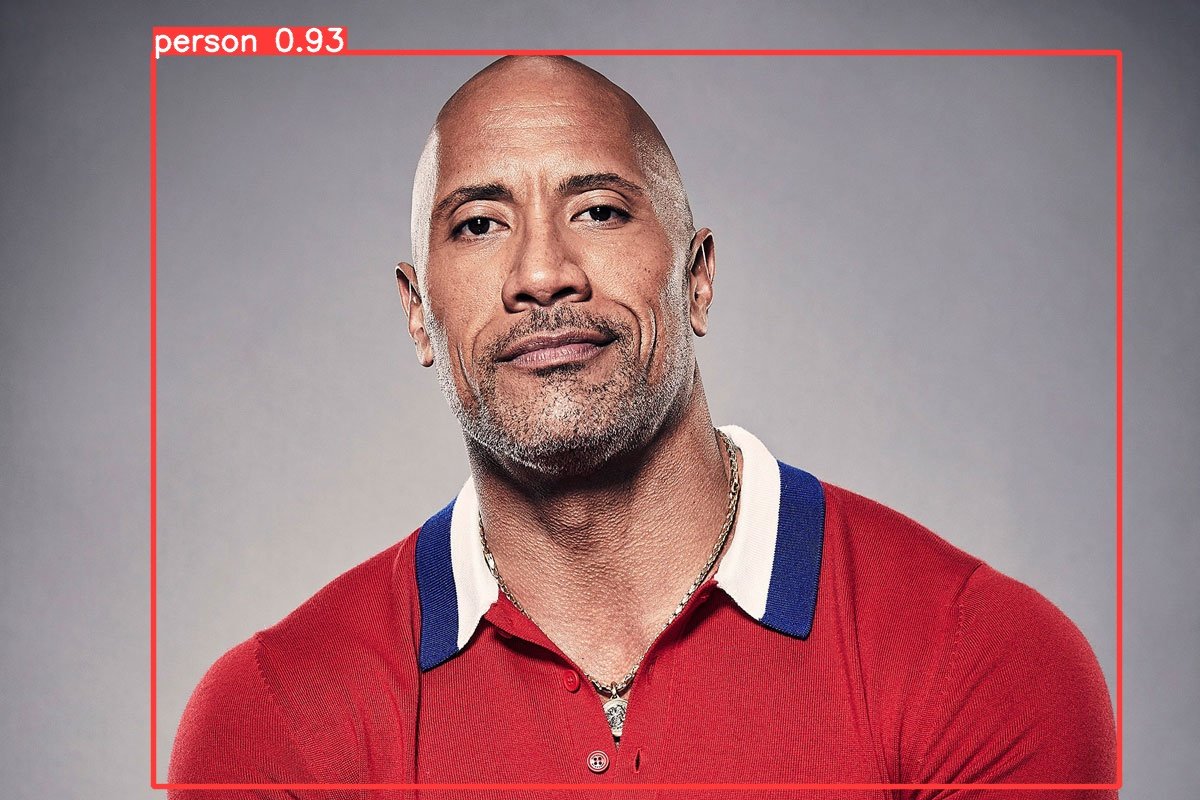

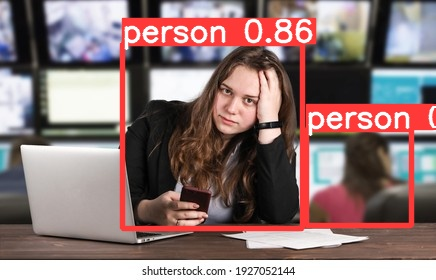

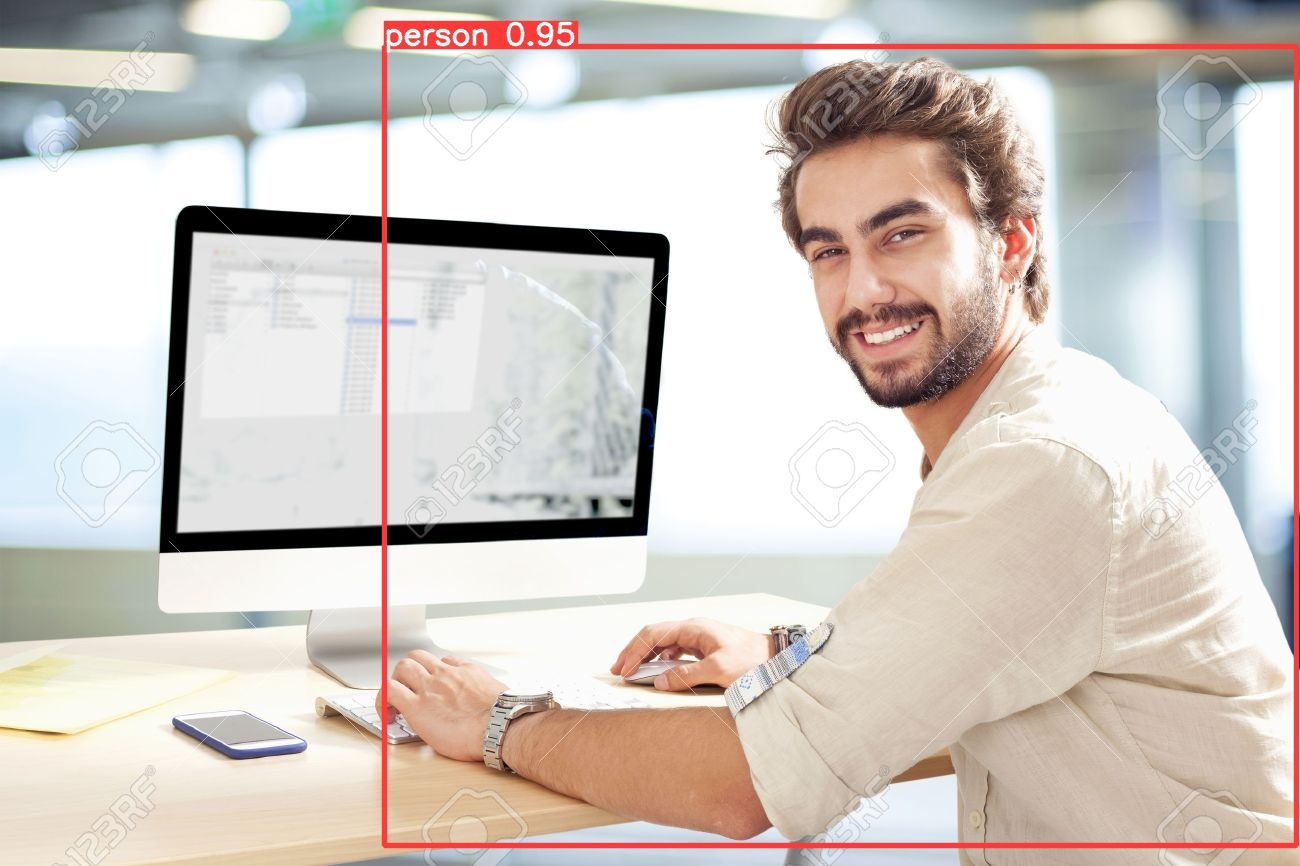

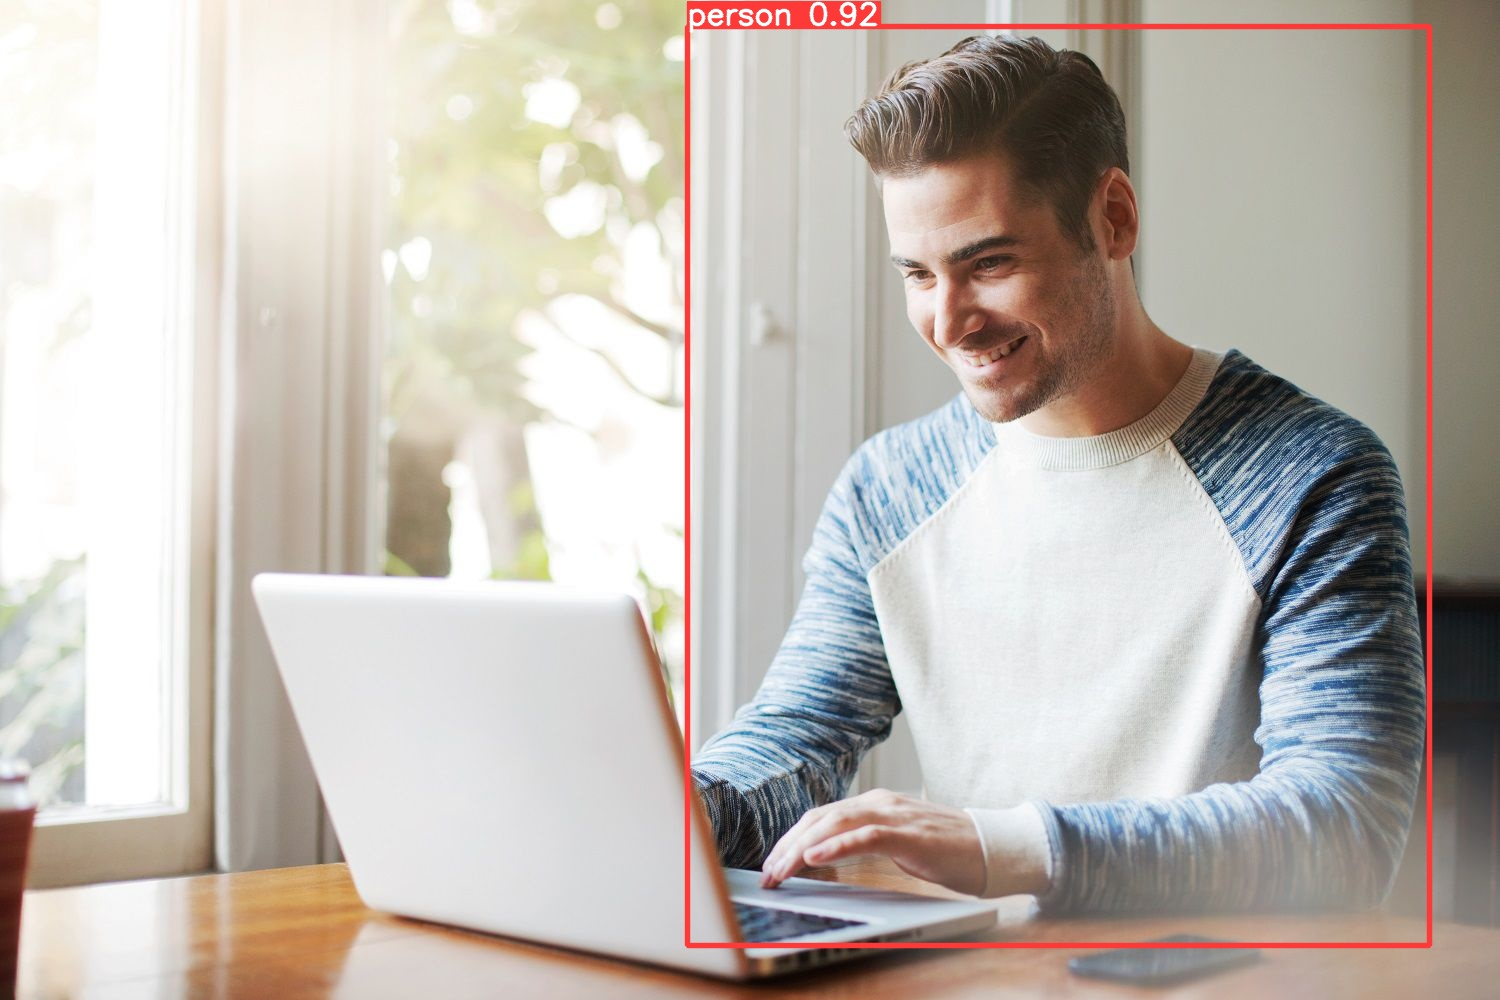

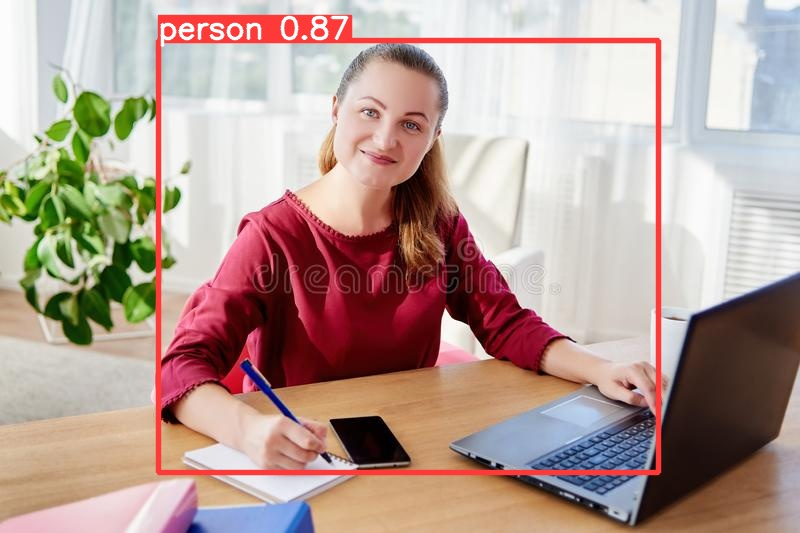

In [ ]:
# Display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
# Zip 'runs/train' (including all 'exp' folders) and 'wandb/latest-run' folder
%cd /content/yolov5/runs/train
!zip -r -0 /content/yolov5-weights-2610.zip .
%cd /content/yolov5/wandb/latest-run
!zip -r -0 /content/yolov5-wandb-2610.zip .

# Save to Google Drive
!cp -r /content/yolov5-weights-2610.zip /content/drive/MyDrive/yolov5/weights/zips
!cp -r /content/yolov5-wandb-2610.zip /content/drive/MyDrive/yolov5/wandb

# Save only the best weights (assume training runs only once)
os.rename('/content/yolov5/runs/train/exp2/weights/best.pt', '/content/yolov5/runs/train/exp2/weights/best-2610.pt')
!cp -r /content/yolov5/runs/train/exp2/weights/best-2610.pt /content/drive/MyDrive/yolov5/weights

In [ ]:
# Naming & Directories

root_dir         = '/content/'
wandb_dir        = os.path.join(yolov5_dir, 'wandb/latest-run')
weights_name_zip = 'weights-1203.zip'                                    # CHANGE THIS EVERY RUN
wandb_name_zip   = 'wandb-1203.zip'                                      # CHANGE THIS EVERY RUN
posttrained_name = 'best-1203.pt'                                               # CHANGE THIS EVERY RUN

weights_zip       = os.path.join(root_dir, weights_name_zip)
wandb_zip         = os.path.join(root_dir, wandb_name_zip)
posttrained_file  = os.path.join(posttrained_weights_dir, posttrained_name)       

target_weights_dir     = '/content/drive/MyDrive/yolov5/weights/zips'
target_wandb_dir       = '/content/drive/MyDrive/yolov5/wandb'
target_posttrained_dir = '/content/drive/MyDrive/yolov5/weights'

if not (os.path.isdir(target_weights_dir) and os.path.isdir(target_wandb_dir) and os.path.isdir(target_posttrained_dir)):
    %%script stop_code_here

# Zip 'runs/train/exp{...}' (only latest 'exp' folder i.e. latest run) & 'wandb/latest-run' folder

!cd $posttrained_dir && zip -r -0 $weights_zip .
!cd $wandb_dir && zip -r -0 $wandb_zip .

# Save to Google Drive
!cp -r $weights_zip $target_weights_dir
!cp -r $wandb_zip $target_wandb_dir

# Save only the best weights file (from the latest run)
!mv $posttrained_weights_file $posttrained_file && cp -r $posttrained_file $target_posttrained_dir

# Playground

In [ ]:
!sudo lshw

dc7f79fb8cea
    description: Computer
    width: 64 bits
    capabilities: smp vsyscall32
  *-core
       description: Motherboard
       physical id: 0
     *-memory
          description: System memory
          physical id: 0
          size: 12GiB
     *-cpu
          product: Intel(R) Xeon(R) CPU @ 2.20GHz
          vendor: Intel Corp.
          physical id: 1
          bus info: cpu@0
          width: 64 bits
          capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
     *-pci
          description: Host bridge
  

In [ ]:
!sudo apt-get install lshw
!sudo lshw -short

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3 pciutils usbutils
The following NEW packages will be installed:
  libpci3 lshw pciutils usbutils
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 723 kB of archives.
After this operation, 2,883 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 lshw amd64 02.18-0.1ubuntu6.18.04.2 [234 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 usbutils amd64 1:007-4build1 [208 kB]
Fetched 723 kB in 1s (558 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based fron

In [ ]:
!free

              total        used        free      shared  buff/cache   available
Mem:       13302924     1140852     6818616        1196     5343456    12056644
Swap:             0           0           0


In [ ]:
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   66G  102G  40% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1       174G   70G  104G  40% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           167G   71G   97G  43% /content/drive
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse3